## Stack Exchange Post text classifiction using Fasttext.

**_Authenticating the google colab with Google SDK_**

In [1]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

%load_ext google.colab.data_table

Authenticated


**_Mouting Google Drive_**

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

directory='/content/drive/My Drive/Comp8240'

!cd '/content/drive/My Drive/COMP8240'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


**_reading project-id from the file_**

In [3]:
with open('/content/drive/My Drive/COMP8240/google_cloud_project_id.txt','r') as f:
  project_id= f.read()

**_loading required libraries_**

In [4]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
import collections                                                               #library to store list, dict,set,tuple                  
from   collections import Counter                                                #library for importing counter, which is a container that stores elements as dictionary keys, and their counts are stored as dictionary values.
import itertools  
import seaborn as sns
from nltk.corpus import stopwords

%matplotlib inline
nltk.download("stopwords")
pd.set_option('mode.chained_assignment', None)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


**_Querying Google Cloud Platform_**

**_Querying Google Cloud Platform_**

_We have connected to Google cloud Platform using a project id (assigned to every user) and then ran a select query with limit to fetch only 500000 records on **stackoverflow_posts** table from the **bigquery public data  stackoverflow database** and created a dataframe._

In [5]:
#Project Id for google cloud platform
project_id = project_id

stack_ovf_data = pd.io.gbq.read_gbq('''
  SELECT * FROM `bigquery-public-data.stackoverflow.stackoverflow_posts`
  LIMIT 500000
''', project_id=project_id, dialect='standard')

print("Shape of the StackOverflow dataset:", stack_ovf_data.shape)
stack_ovf_data.head()

Shape of the StackOverflow dataset: (500000, 20)


,id,title,body,accepted_answer_id,answer_count,comment_count,community_owned_date,creation_date,favorite_count,last_activity_date,last_edit_date,last_editor_display_name,last_editor_user_id,owner_display_name,owner_user_id,parent_id,post_type_id,score,tags,view_count
0,525063,Android Respond To URL in Intent,<p>I want my intent to be launched when the us...,525086.0,1.0,2,NaT,2009-02-08 02:55:56.867000+00:00,65,2016-04-10 03:28:09.653000+00:00,2015-08-15 10:24:12.720000+00:00,None,1529129.0,Isaac Waller,764272.0,NaN,1,132,android|url|android-intent|intentfilter|launch,91060.0
1,14128723,Eclipse -- Progress windows don't show up any ...,<p>I used to see both Building and Cleaning ac...,14128762.0,1.0,0,NaT,2013-01-02 20:31:53.523000+00:00,4,2013-01-02 20:34:55.003000+00:00,NaT,None,NaN,user1499731,NaN,NaN,1,13,java|eclipse,4272.0
2,20728,What's the best way to create ClickOnce deploy...,<p>Our team develops distributed winform apps....,20806.0,2.0,0,NaT,2008-08-21 18:35:04.410000+00:00,5,2015-11-30 02:03:49.403000+00:00,2015-11-30 02:03:49.403000+00:00,None,1321.0,whatknott,1321.0,NaN,1,13,winforms|deployment|clickonce,2534.0
3,6531409,iOS: how to get image dimensions without openi...,<p>In an iOS app I need to provide image filte...,8731972.0,2.0,2,NaT,2011-06-30 07:33:38.647000+00:00,4,2014-04-22 17:16:44.230000+00:00,2012-01-24 07:37:04.003000+00:00,user83950,NaN,user83950,NaN,NaN,1,7,ios4|uikit,2837.0
4,593205,action delegate with zero parameters,<p>I see this line in many online examples of ...,593223.0,2.0,3,NaT,2009-02-27 01:30:27.723000+00:00,6,2012-01-12 01:44:40.020000+00:00,2012-01-12 01:44:40.020000+00:00,None,8677.0,I. J. Kennedy,8677.0,NaN,1,21,c#|delegates|action,12377.0


## **_Exploratory Analysis_**

**_Keeping only important columns in the dataframe for further analysis_**

In [6]:
stack_ovf_clean_data = stack_ovf_data[["tags","body","title","answer_count","creation_date","last_activity_date"]]

#Pre-processing answer_count column.
stack_ovf_clean_data["answer_count"]=stack_ovf_clean_data["answer_count"].fillna(0)
stack_ovf_clean_data["answer_count"]=stack_ovf_clean_data["answer_count"].astype(int)

**_Removing tags column with empy strings._**

_Plotting the graph for top 20 answer counts( answer counts ~ shows how many answers have been posted for every post)_

In [7]:
posts_answer_counts = pd.DataFrame()
posts_answer_counts= stack_ovf_clean_data["answer_count"].value_counts(ascending=False)

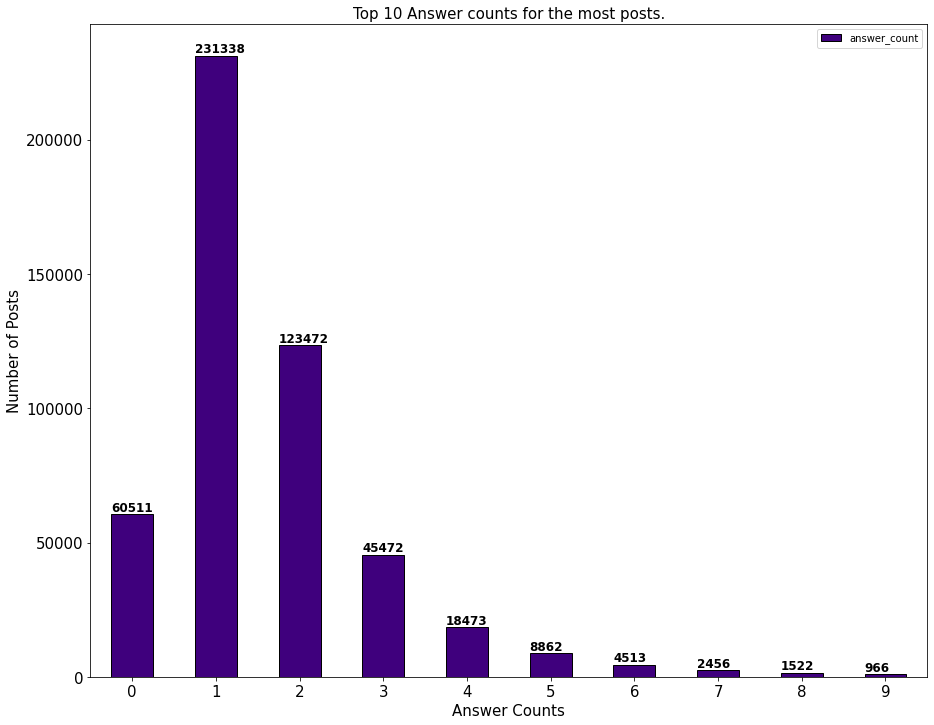

In [8]:
fig, ax = plt.subplots(figsize=(15, 12))

ans_plot=posts_answer_counts[:10].sort_index(ascending=True).plot.bar(x='answer_count',
                      ax=ax,fontsize=15,cmap="Purples_r" ,edgecolor="black")

ax.set_title("Top 10 Answer counts for the most posts.",size=15)
ax.legend().remove()
plt.xlabel("Answer Counts",size=15)
plt.ylabel("Number of Posts",size=15)

for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=360)
plt.show()

In [9]:
posts_wo_answer=posts_answer_counts[0]

print("The",(posts_wo_answer/500000)*100,"% posts have no answers on the StackOverflow.")

The 12.1022 % posts have no answers on the StackOverflow.


**_We observe that 12.049% posts on the StackOverflow are unanswered._**

----

In [10]:
stack_ovf_clean_data['creation_date'] = pd.to_datetime(stack_ovf_clean_data['creation_date']) #converting created_at column to datetime

In [11]:
#Craeting hour, date(full date), only date value, only month value, only year value columns for futhere analysis.
stack_ovf_clean_data['creation_hour'] = stack_ovf_clean_data['creation_date'].dt.hour #creating hour
stack_ovf_clean_data['create_date_sh'] = stack_ovf_clean_data['creation_date'].dt.date
stack_ovf_clean_data['only_date'] = stack_ovf_clean_data['creation_date'].apply(lambda x : str(x)[8:10])
stack_ovf_clean_data['only_month'] = stack_ovf_clean_data['creation_date'].apply(lambda x : str(x)[5:7])
stack_ovf_clean_data["only_year"] = stack_ovf_clean_data["creation_date"].apply(lambda x: str(x)[0:4])

<Figure size 7200x6480 with 0 Axes>

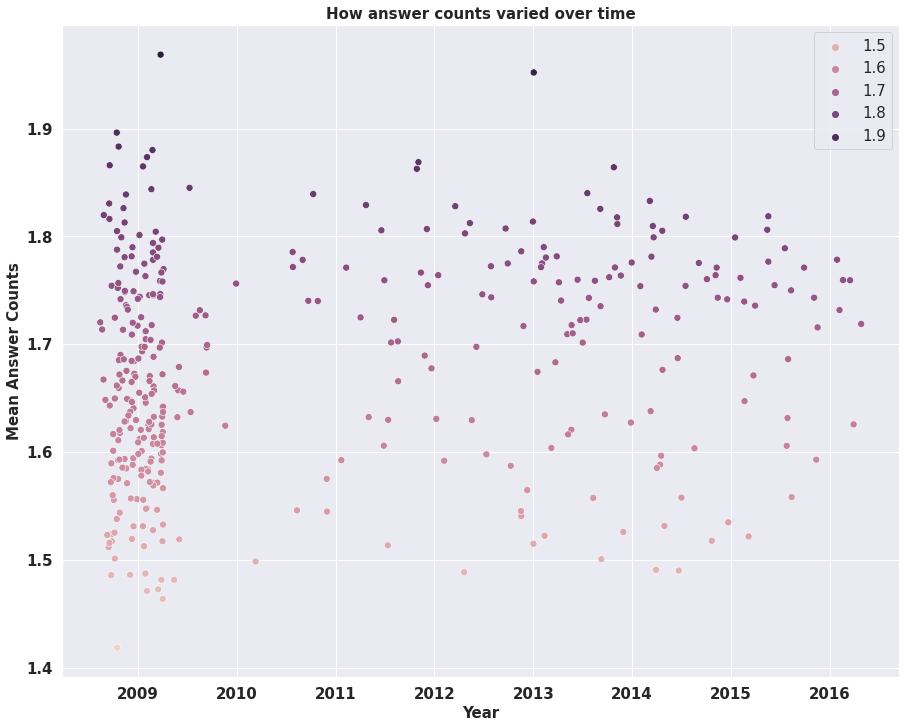

<Figure size 7200x6480 with 0 Axes>

In [12]:
aggdf = stack_ovf_clean_data.reset_index().groupby(by=['only_month', 'only_date']).agg({'answer_count':'mean'}).reset_index().rename(columns={'answer_count':'mean_answer_count'})
aggdf['month_date'] = stack_ovf_clean_data["create_date_sh"]

sns.set(color_codes=True)
fig, ax = plt.subplots(figsize=(15, 12))
sns.scatterplot(x='month_date',y='mean_answer_count', data=aggdf,s=50,hue="mean_answer_count",color="yellow") 
plt.xlabel("Year",size=15,weight='bold')

plt.ylabel("Mean Answer Counts",size=15,weight='bold')
plt.xticks(size=15,weight='bold')
plt.yticks(size=15,weight='bold')
plt.legend(fontsize=15)
plt.title("How answer counts varied over time",size=15,weight='bold')
plt.figure(figsize=(100,90))

**_We observe that the 2009 has most question answered with a cluster of mean values for answer count on daily basis. From 2010 till 2016, we witness the answers were not posted on daily basis and have a scatter plot of answering counts with a wide spread._**

-----

**_Plotting how answer counts varies with time._**

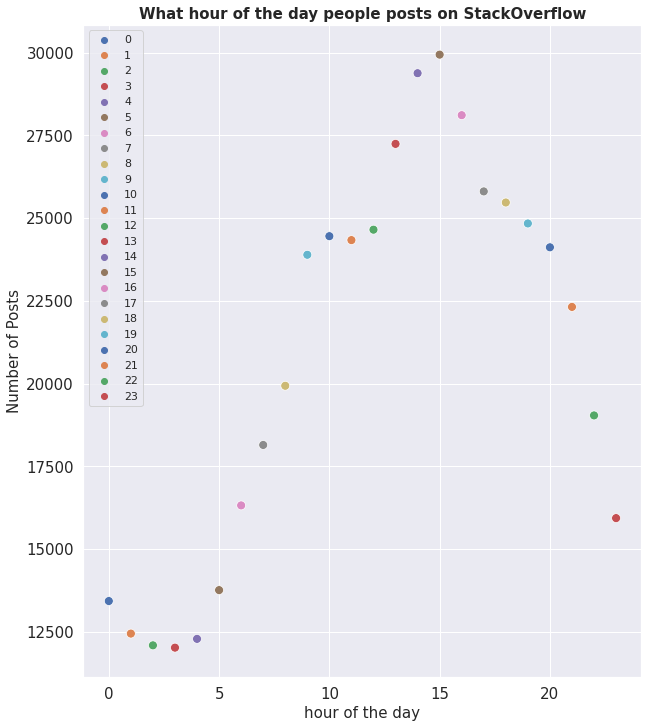

In [13]:
aggdf_1 =pd.DataFrame()
aggdf_1=(stack_ovf_clean_data['creation_hour'].value_counts().sort_index(ascending=True)).astype(int)
aggdf_1=aggdf_1.reset_index().rename(columns={"index":"hour","creation_hour":"Counts"})
fig, ax = plt.subplots(figsize=(10, 12))
sns.set(color_codes=True)
sns.scatterplot(x='hour',y='Counts', data=aggdf_1,s=80,color="red",hue="hour",palette="deep") 

plt.xlabel("hour of the day",size=15)

plt.ylabel("Number of Posts",size=15)
plt.title("What hour of the day people posts on StackOverflow",size=15,weight='bold')
plt.xticks(size=15)
plt.yticks(size=15)
plt.legend(loc="upper left")

**_we observe that people ask questions on StackOverlow throughout the day, around 1400 we have most questions posted and then at 1500 hours we have nearly 30K posts._**

------------

**_Removing rows in tags column with empy string , this means they dont have any tags._**

In [14]:
post_wo_tags =len(stack_ovf_clean_data[stack_ovf_clean_data["tags"]==''])

print("The ",(post_wo_tags/500000)*100,"% posts have no tags (So we are removing them).")

The  11.8788 % posts have no tags (So we are removing them).


In [15]:
stack_ovf_clean_data=stack_ovf_clean_data[stack_ovf_clean_data["tags"]!='']

In [16]:
labels_list = [tags for tags in stack_ovf_clean_data["tags"]]

In [17]:
labels_list_length = [len(tags1.split("|")) for tags1 in labels_list] 

stack_ovf_clean_data["labels_list_length"] = labels_list_length

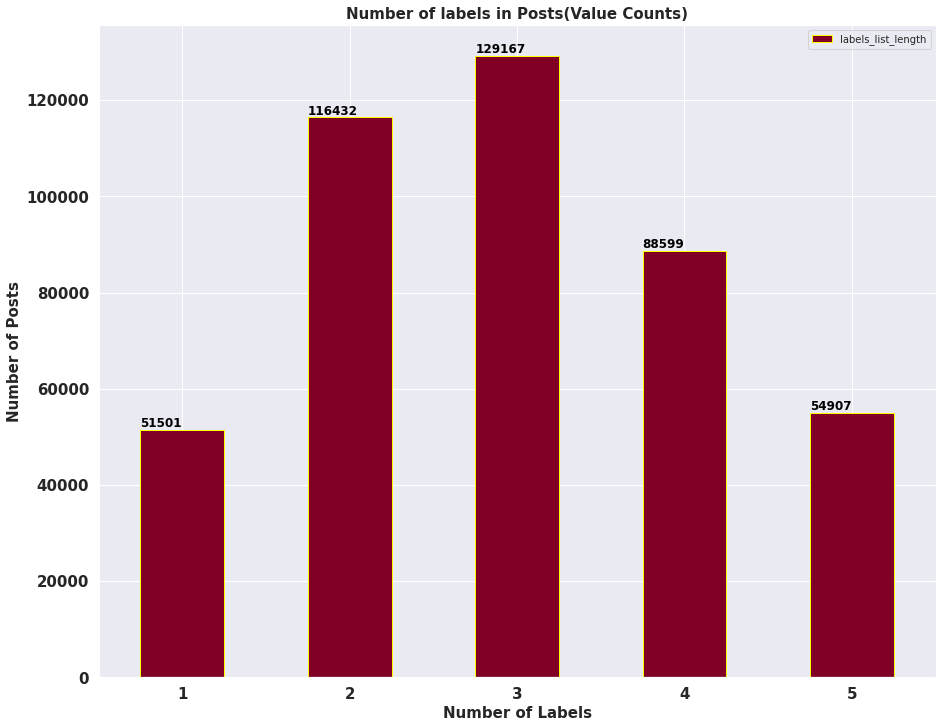

In [18]:
fig, ax = plt.subplots(figsize=(15, 12))

ans_plot=stack_ovf_clean_data["labels_list_length"].value_counts().sort_index(ascending=True).plot.bar(x='labels_list_length',
                      ax=ax,fontsize=15,cmap="YlOrRd_r" ,edgecolor="Yellow")

ans_plot.set_title("Number of labels in Posts(Value Counts)",size=15,weight='bold')
ans_plot.legend().remove()
plt.xlabel("Number of Labels",size=15,weight='bold')
plt.ylabel("Number of Posts",size=15,weight='bold')

for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=360,weight='bold')
plt.yticks(weight='bold')
plt.show()

**_We observe that 129K posts have highest number of 3 lables, where 54K p
osts have 5 labels(most label count) and posts with labels 1 or 5 are more or less similar in count._**

In [19]:
labels_list = [tags for tags in stack_ovf_clean_data["tags"]] 
labels_list = [tags.lower().split("|") for tags in labels_list] 

In [20]:
#chain function which takes a series of iterables and returns one iterable. 
labels_list = list(itertools.chain(*labels_list)) 

#counter function ~ creating a container that stores elements as dictionary keys (words), and their counts(word frequency) are stored as dictionary values
counts_labels = collections.Counter(labels_list)


In [21]:
label_counts_df = pd.DataFrame(counts_labels.most_common(),columns=["labels","counts"])

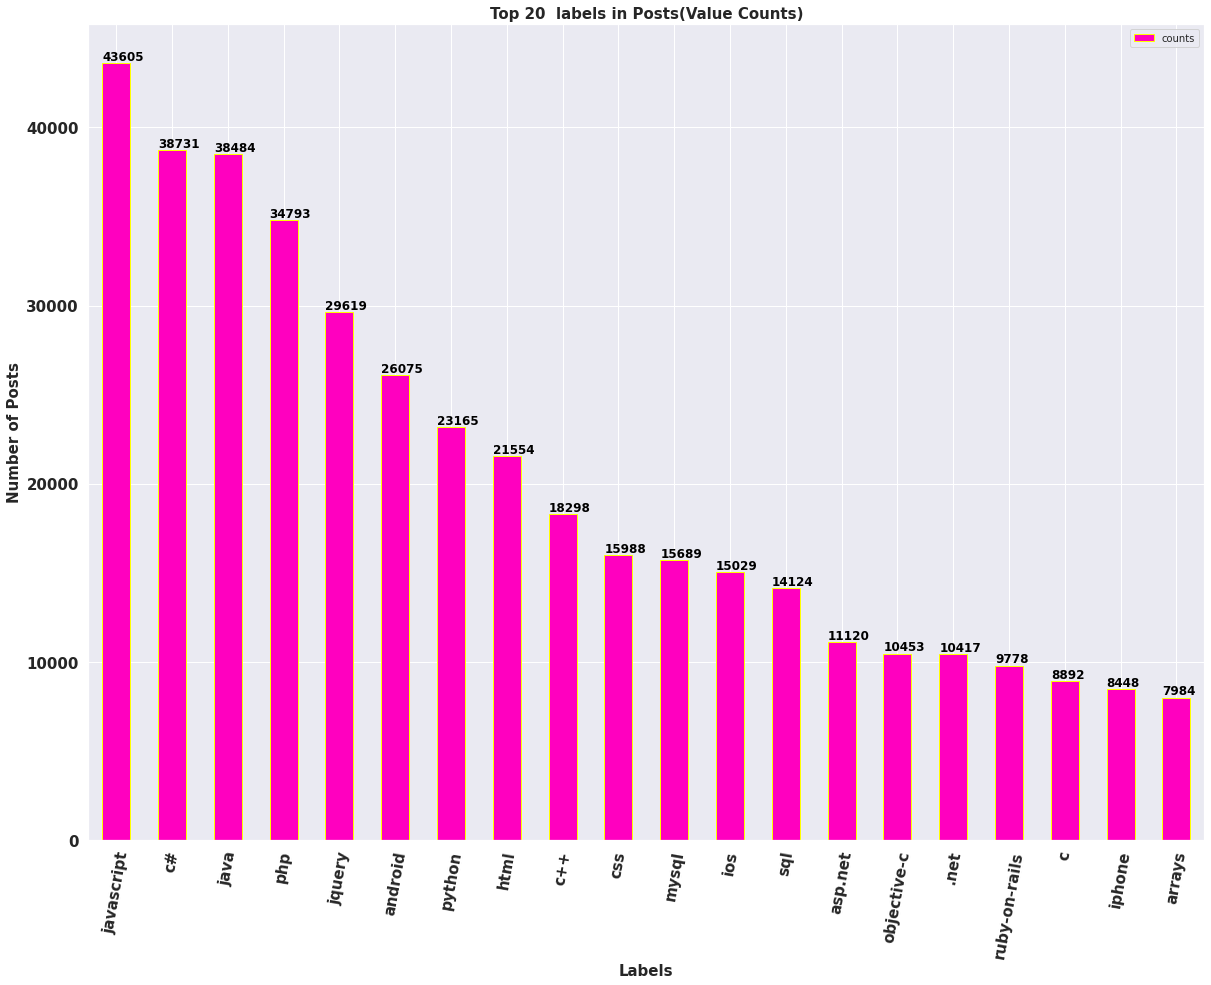

In [22]:
fig, ax = plt.subplots(figsize=(20, 15))
ans_plot=label_counts_df[:20].plot.bar(x='labels',
                      ax=ax,fontsize=15,cmap="gist_rainbow_r" ,edgecolor="Yellow")

ans_plot.set_title("Top 20  labels in Posts(Value Counts)",size=15,weight='bold')
ans_plot.legend().remove()
plt.xlabel("Labels",size=15,weight='bold')
plt.ylabel("Number of Posts",size=15,weight='bold')


for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=80,weight='bold')
plt.yticks(weight='bold')
plt.show()

**_We observe that the javascript is most used label with a frequency of 43K, C# is next in terms of frequency in posts. The plot shows top 20 labels in the posts._**

-----------------------

**_Removing the hyperlinks and url tags as well_**

In [23]:
stack_ovf_clean_data["title"] = stack_ovf_clean_data["title"].str.replace("<.*?>", " ")
stack_ovf_clean_data["title"] = stack_ovf_clean_data["title"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")

stack_ovf_clean_data["body"] = stack_ovf_clean_data["body"].str.replace("<.*?>", " ")
stack_ovf_clean_data["body"] = stack_ovf_clean_data["body"].str.replace(r'https?://[^\s<>"]+|www\.[^\s<>"]+', "")

--------

**_Question lengths for top programming languages_**

In [24]:
#Calculating lenght of questions(body column) and store it in separate column.
stack_ovf_clean_data.loc[:,'length_of_question'] = stack_ovf_clean_data.loc[:,'body'].apply(len)

In [25]:
#Creating a new df and store tags splitted on | (pipe).
prog_df=pd.DataFrame()
prog_df['labels'] = stack_ovf_clean_data['tags'].str.split('|')

In [26]:
#function to filter top programming languages from the list.
def prog_lang(labels):
    lang_list = [lang for lang in labels if lang in ['python','java','sql','r','javascript',"c","c#"]] 
    return lang_list

In [27]:
prog_df['labels'] = prog_df['labels'].apply(prog_lang)

#getting list of labels with only one value.
prog_df= prog_df[(prog_df['labels'].apply(len) > 0) & (prog_df['labels'].apply(len) < 2)]

In [28]:
#converting list of prog languages to string.
prog_df['labels'] = prog_df['labels'].apply(''.join)

In [29]:
prog_df['length_of_question'] = stack_ovf_clean_data['length_of_question']

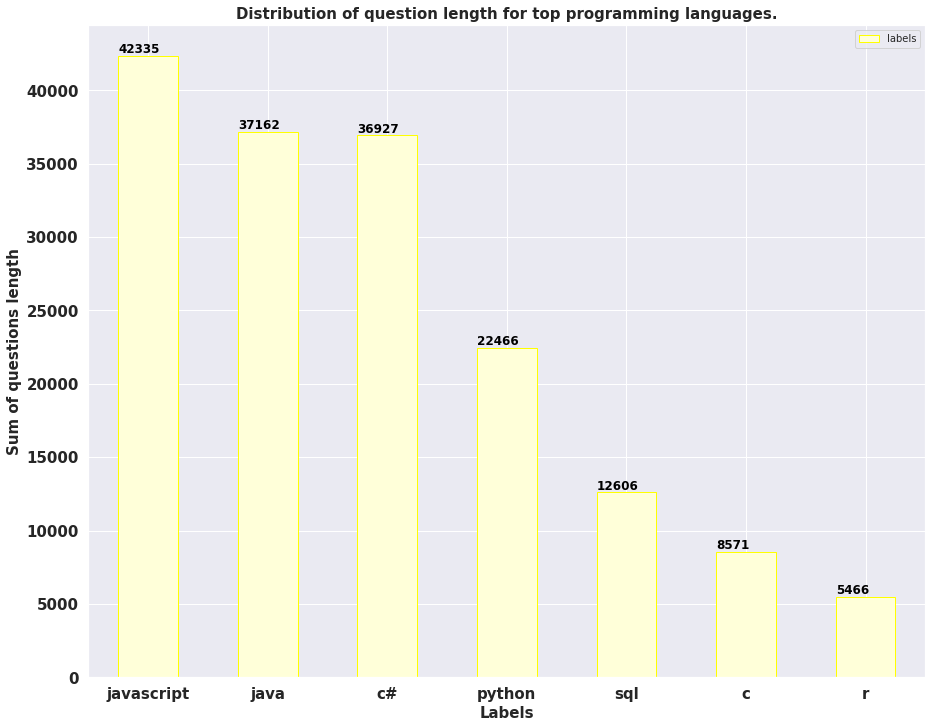

In [30]:
fig, ax = plt.subplots(figsize=(15, 12))

ans_plot=prog_df["labels"].value_counts().plot.bar(x='labels',
                      ax=ax,fontsize=15,cmap="YlGnBu" ,edgecolor="Yellow")

ans_plot.set_title("Distribution of question length for top programming languages.",size=15,weight='bold')
ans_plot.legend().remove()
plt.xlabel("Labels",size=15,weight='bold')
plt.ylabel("Sum of questions length",size=15,weight='bold')

for i in ans_plot.patches:
  ans_plot.text(i.get_x(), i.get_height(),str((i.get_height())), fontsize=12,color='black',ha="left",va="bottom",weight="bold") 
  plt.legend(loc="upper right",fontsize=10)

plt.xticks(rotation=360,weight='bold')
plt.yticks(weight='bold')
plt.show()

**_We obseverve that the javascript tag(label) has most questions with most length (which is obvious as javascript is the most used label by people on the StackOverflow._**

-------

**_changing the case of the words in the tags column_**

In [31]:
# stop_words = set(stopwords.words("english"))
stack_ovf_clean_tags = ' '.join(stack_ovf_clean_data['tags'].str.lower())

**_Printing Word cloud of the tags_**

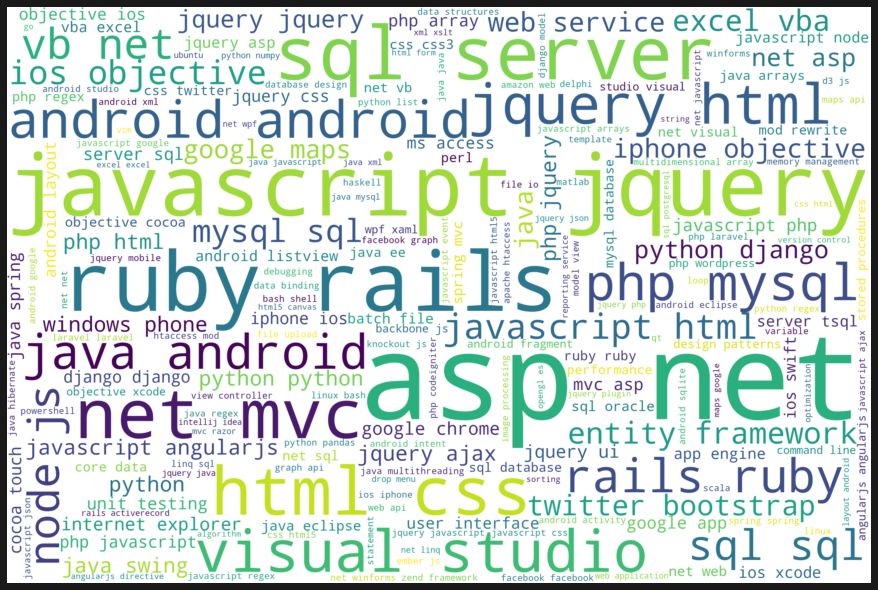

In [32]:
wordcloud = WordCloud(width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = STOPWORDS).generate(stack_ovf_clean_tags)
fig = plt.figure(
    figsize = (12, 12),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

**_WordCloud illustrated the output of the word frequency of the labels, javascript is the highest used label._**

**_Making label column as per requirement for input to the fasttext module._**

In [33]:
stack_ovf_clean_data["tags"] = [item.replace("|", " __label__") for item in stack_ovf_clean_data["tags"]]
stack_ovf_clean_data['tags'] ='__label__' + stack_ovf_clean_data['tags'].astype(str)

In [34]:
 stack_ovf_dataset =stack_ovf_clean_data[["tags","title"]]

In [35]:
stack_ovf_dataset

,tags,title
0,__label__android __label__url __label__android...,Android Respond To URL in Intent
1,__label__java __label__eclipse,Eclipse -- Progress windows don't show up any ...
2,__label__winforms __label__deployment __label_...,What's the best way to create ClickOnce deploy...
3,__label__ios4 __label__uikit,iOS: how to get image dimensions without openi...
4,__label__c# __label__delegates __label__action,action delegate with zero parameters
...,...,...
499995,__label__python __label__list __label__pygame,Python Type error: Int not subscriptable
499996,__label__arrays __label__delphi,Delphi - comparing array to string
499997,__label__android __label__ios __label__faceboo...,Android/iOS app to facebook app
499998,__label__python __label__format,Formatting a basic table
